# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from z3 import *
from itertools import combinations
import sys
sys.path.append('../../scripts/biota/')
from BIoTA_Control import *
sys.path.append('../../scripts/shatter/')
from SHATTER_Control import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Fixed Parameter

In [2]:
CO2_FRESH_AIR = 400             # CO2 concentration (ppm) of fresh air
TEMP_FRESH_AIR = 91.4           # Temperature (33 degree F) of the fresh air
CP_AIR = 1.026                  # Specific heat of fresh air
DEF_TEMP_SUPPLY_AIR =  55.4     # Default temperature (degree fahrenheit) of supply air (13 degree celsius)
MINUTES_IN_A_DAY = 1440         # Number of minutes in a day
OFF_PEAK_ENERGY_COST = 0.34     # OFF-PEAK energy cost (USD)
ON_PEAK_ENERGY_COST = 0.48      # ON-PEAK energy cost (USD)
ON_PEAK_START_SLOT = 960        # ON-PEAK start time (minute in a day)
ON_PEAK_END_SLOT = 1260         # ON-PEAK end time (minute in a day)
BATTER_STORAGE = 0.48           # Energy (kWh) produced by battery
NUM_ZONES = 5
NUM_TIMESLOTS = 1440

# Variable Parameters

In [3]:
zone_temp_setpoint = [0, 75.2, 75.2, 75.2, 75.2]     # list of temperature (fahrenheit) setpoint of the different zones
zone_co2_setpoint = [0, 1000, 1000, 1000, 1000]      # list of CO2 (ppm) setpoint of the corresponding zones
control_time = 1                                     # control time (in minute)

# Accessing Zone-Activity Information

In [4]:
zones = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Zone-Info')
zone_volume = zones["Volume (cf)"].to_list()                  # Zones' volumes (cubic feet)
pp_co2 = zones["CO2 Emission by Occupant (cfm)"].to_list()    # CO2 Emission by Occupant (cfm)
pp_heat = zones["Heat Radiation by Occupant (W)"].to_list()   # Heat Radiation by Occupant (W)
load = zones["Heat Radiated by Appliances (W)"].to_list()     # Heat radiated by Appliances (W)
        
activities = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Activity-Info')

activity_zone_map = dict()
for i in range(len(activities)):
    activity_zone_map[int(activities["Activity ID"][i])] = int(activities["Zone ID"][i])

# Generating Possible Combination of Occupants

In [5]:
import itertools
all_samples = list(itertools.permutations([1, 1, 0, 0, 0]))
all_samples += list(itertools.permutations([2, 0, 0, 0, 0]))
# however, there are repetations

unique_samples = set()

for data in all_samples:    
    unique_samples.add(data)
    
unique_samples

{(0, 0, 0, 0, 2),
 (0, 0, 0, 1, 1),
 (0, 0, 0, 2, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 2, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 1, 0, 0),
 (0, 2, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 1, 0, 0),
 (1, 1, 0, 0, 0),
 (2, 0, 0, 0, 0)}

# Tabulate the Control Costs for all Possible Combinations

In [6]:
# convert list to a tuple
def to_tuple(a):
    try:
        return tuple(to_tuple(i) for i in a)
    except TypeError:
        return a
    
dict_control_cost = dict()
for sample in unique_samples:
    zone_occupant = list(sample)    
    dict_control_cost[sample] = control_cost(zones, zone_occupant, zone_temp_setpoint, zone_volume, pp_co2, pp_heat, load, zone_co2_setpoint, control_time)
dict_control_cost

{(1, 0, 1, 0, 0): 0.006996611666666667,
 (1, 1, 0, 0, 0): 0.006524535000000001,
 (0, 0, 1, 0, 1): 0.036949184833333336,
 (2, 0, 0, 0, 0): 0.0,
 (0, 0, 0, 2, 0): 0.062190949333333335,
 (0, 0, 0, 0, 2): 0.03490514633333333,
 (0, 1, 0, 0, 1): 0.03647710816666667,
 (1, 0, 0, 0, 1): 0.029952573166666666,
 (0, 0, 1, 1, 0): 0.06309208633333334,
 (0, 2, 0, 0, 0): 0.012034600000000001,
 (0, 0, 0, 1, 1): 0.08604804783333334,
 (0, 1, 0, 1, 0): 0.06262000966666667,
 (0, 0, 2, 0, 0): 0.009909890000000001,
 (0, 1, 1, 0, 0): 0.013521146666666668,
 (1, 0, 0, 1, 0): 0.056095474666666666}

# Reading SHATTER Attack-Schedule Datasets

In [7]:
house_A_occ_1_final_schedule = pd.read_csv("../../data/shatter/DBSCAN_House-A_Occ-1_SHATTER_Schedule.csv").values
house_A_occ_2_final_schedule = pd.read_csv("../../data/shatter/DBSCAN_House-A_Occ-2_SHATTER_Schedule.csv").values
house_B_occ_1_final_schedule = pd.read_csv("../../data/shatter/DBSCAN_House-B_Occ-1_SHATTER_Schedule.csv").values
house_B_occ_2_final_schedule = pd.read_csv("../../data/shatter/DBSCAN_House-B_Occ-2_SHATTER_Schedule.csv").values
house_A_occ_1_greedy_schedule =  pd.read_csv("../../data/shatter/DBSCAN_House-A_Occ-1_Greedy_Schedule.csv").values
house_A_occ_2_greedy_schedule =  pd.read_csv("../../data/shatter/DBSCAN_House-A_Occ-2_Greedy_Schedule.csv").values
house_B_occ_1_greedy_schedule =  pd.read_csv("../../data/shatter/DBSCAN_House-B_Occ-1_Greedy_Schedule.csv").values
house_B_occ_2_greedy_schedule =  pd.read_csv("../../data/shatter/DBSCAN_House-B_Occ-2_Greedy_Schedule.csv").values
house_A_control_dataset = pd.read_csv('../../data/processed/Processed-Dataframe_House-A_BIoTA.csv')
house_B_control_dataset = pd.read_csv('../../data/processed/Processed-Dataframe_House-A_BIoTA.csv')

# SHATTER Attack Cost Calculation for House-B (Daily)

In [8]:
day_wise_shatter_cost = []

shatter_cost_house_B = []
unit_energy_costs = []
energy_consumptions = []
prev_day = -1
battery_usage = 0 # in kWh
for j in range(0, 43200, 1440):
    print(j)
    day_wise_cost = 0
    for i in range(len(house_B_occ_1_final_schedule)):
        current_minute = i     
        control_zone_occupants = house_B_control_dataset.iloc[j + i][2:].values

        zone_occupants = [0, 0, 0, 0, 0]
        if control_zone_occupants[0] == 2:
            zone_occupants[0] = 2
        elif control_zone_occupants[0] == 1:
            zone_occupants[0] = 1
            zone_occupants[int(house_B_occ_1_final_schedule[i])] += 1
        elif control_zone_occupants[0] == 0:
            zone_occupants[int(house_B_occ_1_final_schedule[i])] += 1
            zone_occupants[int(house_B_occ_2_final_schedule[i])] += 1
        energy_consumption = dict_control_cost[to_tuple(zone_occupants)]

        if current_minute < ON_PEAK_START_SLOT or current_minute > ON_PEAK_END_SLOT:
            unit_energy_cost = OFF_PEAK_ENERGY_COST
        else:
            if battery_usage < BATTER_STORAGE:
                battery_usage += energy_consumption
                unit_energy_cost = OFF_PEAK_ENERGY_COST
            else:
                unit_energy_cost = ON_PEAK_ENERGY_COST

        current_cost = energy_consumption * unit_energy_cost
        shatter_cost_house_B.append(current_cost)
        unit_energy_costs.append(unit_energy_cost)
        energy_consumptions.append(energy_consumption)
        
        day_wise_cost += current_cost
    day_wise_shatter_cost.append(day_wise_cost)
        
sum(shatter_cost_house_B)

0
1440
2880
4320
5760
7200
8640
10080
11520
12960
14400
15840
17280
18720
20160
21600
23040
24480
25920
27360
28800
30240
31680
33120
34560
36000
37440
38880
40320
41760


299.688077094743

In [9]:
len(day_wise_shatter_cost)

30

# Greedy Attack Cost Calculation for House-B (Daily)

In [10]:
day_wise_greedy_attck_cost = []
greedy_cost_house_B = []
unit_energy_costs = []
energy_consumptions = []
prev_day = -1
battery_usage = 0 # in kWh

for j in range(0, 43200, 1440):
    print(j)
    day_wise_cost = 0
    for i in range(len(house_B_occ_1_greedy_schedule)):
        current_minute = i    
        control_zone_occupants = house_B_control_dataset.iloc[j + i][2:].values

        zone_occupants = [0, 0, 0, 0, 0]
        if control_zone_occupants[0] == 2:
            zone_occupants[0] = 2
        elif control_zone_occupants[0] == 1:
            zone_occupants[0] = 1
            zone_occupants[int(house_B_occ_1_greedy_schedule[i])] += 1
        elif control_zone_occupants[0] == 0:
            zone_occupants[int(house_B_occ_1_greedy_schedule[i])] += 1
            zone_occupants[int(house_B_occ_2_greedy_schedule[i])] += 1

        energy_consumption = dict_control_cost[to_tuple(zone_occupants)]

        if current_minute < ON_PEAK_START_SLOT or current_minute > ON_PEAK_END_SLOT:
            unit_energy_cost = OFF_PEAK_ENERGY_COST
        else:
            if battery_usage < BATTER_STORAGE:
                battery_usage += energy_consumption
                unit_energy_cost = OFF_PEAK_ENERGY_COST
            else:
                unit_energy_cost = ON_PEAK_ENERGY_COST

        current_cost = energy_consumption * unit_energy_cost
        greedy_cost_house_B.append(current_cost)
        unit_energy_costs.append(unit_energy_cost)
        energy_consumptions.append(energy_consumption)
        day_wise_cost += current_cost
    day_wise_greedy_attck_cost.append(day_wise_cost)
sum(greedy_cost_house_B) 

0
1440
2880
4320
5760
7200
8640
10080
11520
12960
14400
15840
17280
18720
20160
21600
23040
24480
25920
27360
28800
30240
31680
33120
34560
36000
37440
38880
40320
41760


307.060545675663

# Accessing Zone-Activity-Appliances Information

In [11]:
zones = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Zone-Info')
zone_volume = zones["Volume (cf)"].to_list()                    
        
activities = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Activity-Info')
energy_appliances = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Appliances-Info').iloc[:,-1].to_numpy()

num_activities = len(activities)  

activity_zone_map = dict()
for i in range(num_activities):
    activity_zone_map[int(activities["Activity ID"][i])] = int(activities["Zone ID"][i])

benign_activity_appliances_map = pd.read_excel('../../data/Aras-Information.xlsx', sheet_name='Benign-Activity-Appliances-Map').iloc[:, 4:].to_numpy()
  
activity_zone_temp_setpoint = [0]
activity_zone_co2_setpoint = [0] 
activity_pp_co2 = [0] + activities['CO2 Emission by Occupant (CFM)'].to_list()    # CO2 Emission by Occupant (cfm)
activity_pp_heat = [0] + activities["Heat Radiation by Occupant (W)"].to_list()   # Heat Radiation by Occupant (W)
activity_load = [0]# Heat radiated by Appliances (W)
activity_zone_volume = [0]

for i in range(1, num_activities + 1):
    activity_zone_temp_setpoint.append(zone_temp_setpoint[activity_zone_map[i]])
    activity_zone_co2_setpoint.append(zone_co2_setpoint[activity_zone_map[i]])
    activity_zone_volume.append(zone_volume[activity_zone_map[i]])
    activity_load.append(sum(benign_activity_appliances_map[i] * energy_appliances))

# Generating Possible Combination of Occupants

In [12]:
import itertools
all_samples = list(itertools.permutations([1, 1, 0, 0, 0]))
all_samples += list(itertools.permutations([2, 0, 0, 0, 0]))
# however, there are repetations

unique_samples = set()

for data in all_samples:    
    unique_samples.add(data)
    
unique_samples

{(0, 0, 0, 0, 2),
 (0, 0, 0, 1, 1),
 (0, 0, 0, 2, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 2, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 1, 0, 0),
 (0, 2, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 1, 0, 0),
 (1, 1, 0, 0, 0),
 (2, 0, 0, 0, 0)}

# Tabulate the Control Costs for all Possible Combinations

In [13]:
# convert list to a tuple
def to_tuple(a):
    try:
        return tuple(to_tuple(i) for i in a)
    except TypeError:
        return a
    
dict_control_cost = dict()
for sample in unique_samples:
    zone_occupant = list(sample)    
    dict_control_cost[sample] = control_cost(zones, zone_occupant, zone_temp_setpoint, zone_volume, pp_co2, pp_heat, load, zone_co2_setpoint, control_time)
dict_control_cost

{(1, 0, 1, 0, 0): 0.006996611666666667,
 (1, 1, 0, 0, 0): 0.006524535000000001,
 (0, 0, 1, 0, 1): 0.036949184833333336,
 (2, 0, 0, 0, 0): 0.0,
 (0, 0, 0, 2, 0): 0.062190949333333335,
 (0, 0, 0, 0, 2): 0.03490514633333333,
 (0, 1, 0, 0, 1): 0.03647710816666667,
 (1, 0, 0, 0, 1): 0.029952573166666666,
 (0, 0, 1, 1, 0): 0.06309208633333334,
 (0, 2, 0, 0, 0): 0.012034600000000001,
 (0, 0, 0, 1, 1): 0.08604804783333334,
 (0, 1, 0, 1, 0): 0.06262000966666667,
 (0, 0, 2, 0, 0): 0.009909890000000001,
 (0, 1, 1, 0, 0): 0.013521146666666668,
 (1, 0, 0, 1, 0): 0.056095474666666666}

# Zone-wise Appliances

In [14]:
zone_appliance = []
zone_appliance.append([1, 2]) #0
zone_appliance.append([11, 16, 17, 23, 27]) #1
zone_appliance.append([12, 13, 18, 22, 25, 26]) #2
zone_appliance.append([3, 4, 5, 6, 7, 8, 9, 10, 19, 24]) #3
zone_appliance.append([14, 15, 20, 21]) #4

for i in range(len(zone_appliance)):
    print(len(zone_appliance[i]))

2
5
6
10
4


# Zone-wise Maximum Cost For Appliances

In [15]:
zone_cost = [0, 0, 0, 0, 0]
for i in range(len(zone_cost)):
    all_costs = []
    for j in range(len(zone_appliance[i])):
        all_costs.append(activity_load[zone_appliance[i][j]])
    zone_cost[i] =  max(all_costs)
zone_cost

[0, 256, 270, 5127, 1518]

# Clustering and Convex Hull

In [16]:
# returns dbscan clusters
def dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    cluster = db.fit(X)
    #y_pred = db.fit_predict(X)
    #plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    #plt.title("DBSCAN")
    #print("noise", sum(cluster.labels_ ==-1), "regular", sum(cluster.labels_ !=-1))
    #print(np.unique(cluster.labels_))
    return cluster

# returns convex hull of points associated with zones
def convex_hull(zone, points):
        '''
        Parameters
        ----------
        points : Array
            A set of points.
            
        Returns
        -------
        vertices : Points
            Arranges convex hull vertices in counter-clockwise orientation.
        '''    
        
        hull = ConvexHull(points)
        
        
        #plt.plot(points[:,0], points[:,1], 'o')
        #plt.ylim(0,120)
        #for simplex in hull.simplices:
        #    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
            
        simplices = hull.simplices
        
        vertices = []
        for index in hull.vertices:
            vertices.append((points[index][0], zone, points[index][1]))
        vertices.append((points[hull.vertices[0]][0], zone, points[hull.vertices[0]][1]))
        
        return vertices

# Cluster Boundary Acquisition

In [17]:
def get_cluster(dataframe, eps, min_samples):
    list_cluster = []
        
    count = 0
    for zone in range(NUM_ZONES):
        mod_dataframe = dataframe[['Occupant\'s Zone','Zone Arrival Time (Minute)', 'Stay Duration (Minute)']].values
        features = mod_dataframe[mod_dataframe[:,0] == zone][:,1:]
        
        cluster_model = dbscan(features, eps, min_samples)
        labels = cluster_model.labels_
                
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            points = []
            for k in range(len(labels)):
                if labels[k] == cluster:
                    points.append(features[k])

            if len(points) >= 3:
                try:
                    vertices = convex_hull(zone, points)       
                except:
                    pass
            list_cluster.append({"zone_id": zone, "cluster_id": cluster, "points": vertices})
            
    return list_cluster

# Reading Clean Dataframes

In [18]:
cleaned_duration_dataframe_house_A_occ_1 = pd.read_csv("../../data/cleaned/Cleaned-Dataframe_House-A_Occupant-1.csv")
cleaned_duration_dataframe_house_A_occ_2 = pd.read_csv("../../data/cleaned/Cleaned-Dataframe_House-A_Occupant-2.csv")
cleaned_duration_dataframe_house_B_occ_1 = pd.read_csv("../../data/cleaned/Cleaned-Dataframe_House-B_Occupant-1.csv")
cleaned_duration_dataframe_house_B_occ_2 = pd.read_csv("../../data/cleaned/Cleaned-Dataframe_House-B_Occupant-2.csv")

# Get Cluster Information

In [19]:
clusters_house_A_occ_1 = get_cluster(cleaned_duration_dataframe_house_A_occ_1, 30, 3)
clusters_house_A_occ_2 = get_cluster(cleaned_duration_dataframe_house_A_occ_2, 26, 3)
clusters_house_B_occ_1 = get_cluster(cleaned_duration_dataframe_house_B_occ_1, 30, 3)
clusters_house_B_occ_2 = get_cluster(cleaned_duration_dataframe_house_B_occ_2, 30, 3)

# Range Claculation Function

In [20]:
def is_left( x, y, init_x, init_y, final_x, final_y):
     return ((final_x - init_x)*(y - init_y) - (final_y - init_y)*(x - init_x)) >= 0

def range_calculation(list_cluster):
    
    list_time_min = [[[] for j in range(NUM_TIMESLOTS)] for i in range(NUM_ZONES + 1)]
    list_time_max = [[[] for j in range(NUM_TIMESLOTS)] for i in range(NUM_ZONES + 1)]

    for i in range(len(list_cluster)):
        zone_id = list_cluster[i]["zone_id"]
        min_x_range = 1440
        max_x_range = 0

        ##################################################################
        ##################### Zone Constraints ###########################
        ##################################################################
        x = Int('x')
        y = Int('y')

        points = list_cluster[i]["points"]
        for i in range(len(points)):
            for j in range(len(points[i])):
                points[i] = list(points[i])
                points[i][j] = int(points[i][j])
        zone_constraints = []

        and_constraints = []
        for j in range(len(points) - 1):
            and_constraints.append(is_left(x, y, points[j][0], points[j][2], points[j + 1][0], points[j + 1][2]))

        zone_constraints.append(And(and_constraints))

        #print(zone_constraints)
        ####### Minimum value of X range #######
        o = Optimize()
        o.add(zone_constraints)
        o.minimize(x)
        o.check()
        
        min_x_range = int(str(o.model()[x]))

        ####### Maximum value of X range #######
        o = Optimize()
        o.add(zone_constraints)
        o.maximize(x)
        o.check()
        #print(o.model()[x])

        max_x_range = int(str(o.model()[x]))
        
        
        for j in range(min_x_range, max_x_range):
            ####### Minimum value of Y range #######
            o = Optimize()
            o.add(zone_constraints)
            o.add(x == j)
            o.minimize(y)
            o.check()

            min_y_range = o.model()[y]
            if min_y_range == None:
                min_y_range = 0

            ####### Maximum value of Y range #######
            o = Optimize()
            o.add(zone_constraints)
            o.add(x == j)
            o.maximize(y)
            o.check()

            max_y_range = o.model()[y]
            if max_y_range == None:
                max_y_range = 0
                
            list_time_min[zone_id][j].append(int(str(min_y_range)))
            list_time_max[zone_id][j].append(int(str(max_y_range)))
#         for i in range(len(zone_time_val)):
#             zone = zone_time_val[i][0]
#             time = zone_time_val[i][1]
#             val = zone_time_val[i][2]
#             list_time_min[zone][time].append(val)
#             list_time_max[zone][time].append(val)
            
    return list_time_min, list_time_max

# Range Calculation (House B)

In [21]:
list_time_min_house_B_occ_1, list_time_max_house_B_occ_1 = range_calculation(clusters_house_B_occ_1)
list_time_min_house_B_occ_2, list_time_max_house_B_occ_2 = range_calculation(clusters_house_B_occ_2)

# House-B Appliance Triggerring Cost Calculation

In [22]:
occ_1_zones = []
occ_2_zones = []

clean_dataframe_house_B = pd.read_csv("../../data/processed/Processed-Dataframe_House-B_SHATTER.csv")

for i in range(len(clean_dataframe_house_B)):
    occ_1_zones.append(activity_zone_map[clean_dataframe_house_B['Occupant-1 Activity'][i]])
    occ_2_zones.append(activity_zone_map[clean_dataframe_house_B['Occupant-2 Activity'][i]])

clean_dataframe_house_B['Occupant-1 Zone'] = occ_1_zones
clean_dataframe_house_B['Occupant-2 Zone'] = occ_2_zones

In [23]:
clean_dataframe_house_B

,Day,Minute,Occupant-1 Activity,Occupant-2 Activity,Occupant-1 Zone,Occupant-2 Zone
0,1,0,11,11,1,1
1,1,1,11,11,1,1
2,1,2,11,11,1,1
3,1,3,11,11,1,1
4,1,4,11,11,1,1
...,...,...,...,...,...,...
43195,30,1435,11,11,1,1
43196,30,1436,11,11,1,1
43197,30,1437,11,11,1,1
43198,30,1438,11,11,1,1


In [24]:
day_wise_appl_cost_house_B_occ_1 = []
## house A occ 1
for i in range(0, 43200, 1440):
    cost = 0
    entrances = []
    prev_zone = clean_dataframe_house_B['Occupant-1 Zone'][i]
    attackable = np.zeros((1440))
    for j in range(i, i + 1440):
        zone_occupants = [0, 0, 0, 0, 0]
        zone_occupants[clean_dataframe_house_B['Occupant-1 Zone'][j]] += 1
        zone_occupants[clean_dataframe_house_B['Occupant-2 Zone'][j]] += 1
        # print(zone_occupants)
        if clean_dataframe_house_B['Occupant-1 Zone'][j] != prev_zone:
            entrances.append([j%1440, clean_dataframe_house_B['Occupant-1 Zone'][j]])
            prev_zone = clean_dataframe_house_B['Occupant-1 Zone'][j]
    for j in range(len(entrances) - 1):
        zone = entrances[j][1]
        time = entrances[j][0] 
        if len(list_time_min_house_B_occ_1[zone][time]) == 0:
            #print("Here")
            attack_time = 0
        else:
            attack_time = min(entrances[j + 1][0] - entrances[j][0], list_time_min_house_B_occ_1[zone][time][0])
        attackable[entrances[j][0] : entrances[j][0] + attack_time] = 1
        #print(entrances[j][0], attack_time)
    for j in range(len(attackable)):
        if attackable[j] == 1:
            COST_PER_KWH = 0.395
            cost += (zone_cost[house_B_occ_1_final_schedule[j][0]] / 60000 ) * COST_PER_KWH
    day_wise_appl_cost_house_B_occ_1.append(cost)

In [25]:
day_wise_appl_cost_house_B_occ_2 = []
## house A occ 1
for i in range(0, 43200, 1440):
    cost = 0
    entrances = []
    prev_zone = clean_dataframe_house_B['Occupant-2 Zone'][i]
    attackable = np.zeros((1440))
    for j in range(i, i + 1440):
        zone_occupants = [0, 0, 0, 0, 0]
        zone_occupants[clean_dataframe_house_B['Occupant-1 Zone'][j]] += 1
        zone_occupants[clean_dataframe_house_B['Occupant-2 Zone'][j]] += 1
        # print(zone_occupants)
        if clean_dataframe_house_B['Occupant-2 Zone'][j] != prev_zone:
            entrances.append([j%1440, clean_dataframe_house_B['Occupant-2 Zone'][j]])
            prev_zone = clean_dataframe_house_B['Occupant-2 Zone'][j]
    for j in range(len(entrances) - 1):
        zone = entrances[j][1]
        time = entrances[j][0] 
        if len(list_time_min_house_B_occ_2[zone][time]) == 0:
            #print("Here")
            attack_time = 0
        else:
            attack_time = min(entrances[j + 1][0] - entrances[j][0], list_time_min_house_B_occ_2[zone][time][0])
        attackable[entrances[j][0] : entrances[j][0] + attack_time] = 1
        #print(entrances[j][0], attack_time)
    for j in range(len(attackable)):
        if attackable[j] == 1:
            COST_PER_KWH = 0.395
            cost += (zone_cost[house_B_occ_2_final_schedule[j][0]] / 60000 ) * COST_PER_KWH
    day_wise_appl_cost_house_B_occ_2.append(cost)

In [26]:
house_B_appl_cost = np.array(day_wise_appl_cost_house_B_occ_1) + np.array(day_wise_appl_cost_house_B_occ_2)

In [27]:
sum(house_B_appl_cost)

60.033199416666704

In [28]:
sum(day_wise_shatter_cost)

299.6880770947239

In [29]:
sum(house_B_appl_cost)/sum(day_wise_shatter_cost)

0.2003189449465209

# Plotting Function

In [30]:
def plotting(benign, base_data, cost_data, location, ylim_range):
    legendlist=['Benign Control Cost', 'Without Appliance Triggering Attack','With Appliance Triggering Attack' ]
    markers=['v','o','s']
    fig= plt.figure(figsize=(8,6.5))
    plt.grid()
    plt.plot(benign, marker=markers[0], linewidth=3, markersize=12)
    plt.plot(base_data, marker=markers[1], linewidth=3, markersize=12)
    plt.plot(cost_data, marker=markers[2], linewidth=3, markersize=12)
    plt.legend(legendlist,loc='upper left',fontsize="20")
    plt.yticks(fontsize="20")
    plt.xticks(fontsize="20")
    plt.ylim(ylim_range)
    plt.xlabel("Day of the Month",fontsize="24")
    plt.ylabel("Control Cost ($)",fontsize="24")
    plt.savefig(location + '.pdf', bbox_inches='tight')

# SHATTER Benign Cost

In [31]:
shatter_house_B = pd.read_csv("../../data/shatter/SHATTER-Control-Dataframe_House-B.csv")
day_wise_shatter_benign_cost = []
for i in range(0, 43200, 1440):
    day_wise_shatter_benign_cost.append(sum(shatter_house_B["Control Cost ($)"][i:i+1400]))
total_shatter_benign_cost_house_B = sum(day_wise_shatter_benign_cost)
total_shatter_benign_cost_house_B

75.70253333797343

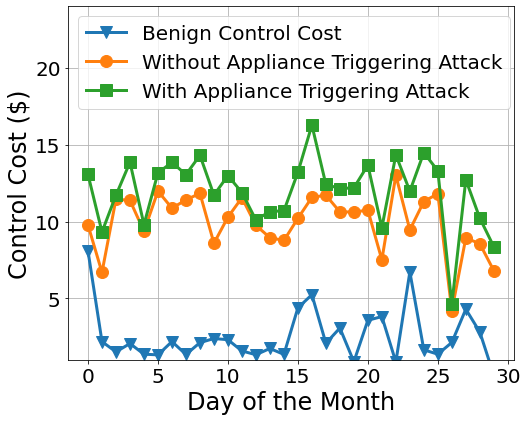

In [32]:
location = "../../plots/House-B_Appl_Cost"
ylim_range = [1, 24]
plotting(day_wise_shatter_benign_cost, day_wise_shatter_cost, day_wise_shatter_cost + house_B_appl_cost, location, ylim_range)